In [ ]:
import os
import json
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy.optimize import curve_fit

# --- Core analysis functions (UNCHANGED) ---
def pendulum_velocity(x, k, r, phi):
    return np.sqrt(np.maximum(0, 2 * k * (r - np.cos(x - phi))))


def bin_and_fit(angle_forv, angle_v, angle_bins):
    median_velocity, pct_95_velocity, std_err_median = [], [], []
    bin_centers = (angle_bins[:-1] + angle_bins[1:]) / 2
    bin_width = angle_bins[1] - angle_bins[0]
    for i in range(len(angle_bins) - 1):
        mask = (angle_forv >= angle_bins[i]) & (angle_forv < angle_bins[i + 1])
        if np.any(mask):
            vals = angle_v[mask]
            median_velocity.append(np.median(vals))
            pct_95_velocity.append(np.percentile(vals, 95))
            std_err_median.append(np.std(vals))
        else:
            median_velocity.append(np.nan)
            pct_95_velocity.append(np.nan)
            std_err_median.append(np.nan)
    return (
        np.array(median_velocity),
        np.array(pct_95_velocity),
        np.array(std_err_median),
        _fit_popt(bin_centers, np.array(median_velocity)),
        bin_centers,
        bin_width
    )


def _fit_popt(bin_centers, median_velocity):
    valid = ~np.isnan(median_velocity)
    try:
        popt, _ = curve_fit(
            pendulum_velocity,
            bin_centers[valid],
            np.abs(median_velocity[valid]),
            p0=[0.1, 1, 0],
            bounds=([0, 0, -np.pi], [10, 10, np.pi])
        )
    except Exception:
        popt = [0.1, 1, 0]
    return popt


def calculate_angles(frames, x1, y1, x2, y2, center1, center2):
    angles_obj1, angles_obj2 = [], []
    for xi1, yi1, xi2, yi2 in zip(x1, y1, x2, y2):
        angle1 = np.arctan2(yi1 - center1[1], xi1 - center1[0])
        angle2 = np.arctan2(yi2 - center2[1], xi2 - center2[0])
        angles_obj1.append(angle1)
        angles_obj2.append(angle2)
    return angles_obj1, angles_obj2


def calculate_velocities(frames, angles_obj1, angles_obj2):
    """
    Calculate angular velocities using full-series unwrap and diff, then filter outliers.
    """
    # Subsample every 6th frame and angle
    np_angles1 = np.array(angles_obj1[::6])
    np_angles2 = np.array(angles_obj2[::6])
    np_frames = np.array(frames[::6])

    # Unwrap entire series for continuity
    unwrapped1 = np.unwrap(np_angles1)
    unwrapped2 = np.unwrap(np_angles2)

    # Compute angular velocity via diff
    dt = np.diff(np_frames)
    ang_vel1 = np.diff(unwrapped1) / dt
    ang_vel2 = np.diff(unwrapped2) / dt

    # Use angle at start of each interval for phase
    angle_forv1 = np_angles1[:-1]
    angle_forv2 = np_angles2[:-1]

    # Absolute velocities
    angle_v1 = np.abs(ang_vel1)
    angle_v2 = np.abs(ang_vel2)

    # Filter outliers
    angle_v1 = filter_outliers(angle_v1)
    angle_v2 = filter_outliers(angle_v2)

    # Mask valid data
    idx1 = ~np.isnan(angle_v1)
    idx2 = ~np.isnan(angle_v2)

    # Return cleaned velocity and corresponding phase arrays
    return (
        angle_v1[idx1],
        angle_v2[idx2],
        angle_forv1[idx1],
        angle_forv2[idx2]
    )


def filter_outliers(data):
    q1, q3 = np.percentile(data, [25, 75])
    iqr = q3 - q1
    lb, ub = q1 - 1.5*iqr, q3 + 1.5*iqr
    return np.where((data < lb) | (data > ub), np.nan, data)


def plot_results(frames, angles1, angles2, ang_for1, ang_v1, ang_for2, ang_v2, x1, y1, x2, y2):
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    axs = axs.flatten()

    # bins for phase plots
    bins = np.arange(-np.pi, np.pi, np.pi/8)
    med1, pct951, std1, popt1, centers1, bw = bin_and_fit(ang_for1, ang_v1, bins)
    med2, pct952, std2, popt2, centers2, _ = bin_and_fit(ang_for2, ang_v2, bins)
    x_fit = np.linspace(-np.pi, np.pi, 1000)
    y_fit1 = pendulum_velocity(x_fit, *popt1)
    y_fit2 = pendulum_velocity(x_fit, *popt2)

    # Prepare per-bin data for boxplots
    data1 = [ang_v1[(ang_for1 >= bins[i]) & (ang_for1 < bins[i+1])] for i in range(len(bins)-1)]
    data2 = [ang_v2[(ang_for2 >= bins[i]) & (ang_for2 < bins[i+1])] for i in range(len(bins)-1)]

    # Phase plot obj1 with thinner boxplots
    axs[0].scatter(ang_for1, ang_v1, alpha=0.2, color='green', label='Raw Data')
    axs[0].boxplot(data1, positions=centers1, widths=bw*0.4, patch_artist=True,
                   boxprops=dict(facecolor='lightgreen'), medianprops=dict(color='red'))
    axs[0].plot(centers1, med1, 'ro-', label='Median')
    axs[0].plot(centers1, pct951, 'mo--', label='95th pct')
    axs[0].plot(x_fit, y_fit1, 'b-', label='Fit')
    axs[0].set_title('Object 1 Phase')
    axs[0].set_xticks(centers1)
    axs[0].set_xticklabels([f"{c:.2f}" for c in centers1], rotation=45)
    axs[0].set_xlabel('Angle (rad)')
    axs[0].set_ylabel('Angular Vel')
    axs[0].legend()
    axs[0].grid()

    # Phase plot obj2 with thinner boxplots
    axs[1].scatter(ang_for2, ang_v2, alpha=0.2, color='blue', label='Raw Data')
    axs[1].boxplot(data2, positions=centers2, widths=bw*0.4, patch_artist=True,
                   boxprops=dict(facecolor='lightblue'), medianprops=dict(color='red'))
    axs[1].plot(centers2, med2, 'ro-', label='Median')
    axs[1].plot(centers2, pct952, 'mo--', label='95th pct')
    axs[1].plot(x_fit, y_fit2, 'b-', label='Fit')
    axs[1].set_title('Object 2 Phase')
    axs[1].set_xticks(centers2)
    axs[1].set_xticklabels([f"{c:.2f}" for c in centers2], rotation=45)
    axs[1].set_xlabel('Angle (rad)')
    axs[1].set_ylabel('Angular Vel')
    axs[1].legend()
    axs[1].grid()

    # Angle over time
    axs[2].plot(frames, angles1, label='Obj1 Angle')
    axs[2].plot(frames, angles2, label='Obj2 Angle')
    axs[2].set_title('Angle vs Time')
    axs[2].set_xlabel('Frame')
    axs[2].set_ylabel('Angle (rad)')
    axs[2].legend()
    axs[2].grid()

    # Overall distribution boxplot
    if len(ang_v1)>0 and len(ang_v2)>0:
        bp = axs[3].boxplot([ang_v1, ang_v2], labels=['Obj1','Obj2'], patch_artist=True)
        for patch, color in zip(bp['boxes'], ['lightblue','lightgreen']): patch.set_facecolor(color)
        axs[3].plot(1, np.median(ang_v1), 'ro', label='Obj1 Median')
        axs[3].plot(2, np.median(ang_v2), 'ro', label='Obj2 Median')
        p1 = mpatches.Patch(facecolor='lightblue', label='Obj1 Dist')
        p2 = mpatches.Patch(facecolor='lightgreen', label='Obj2 Dist')
        axs[3].legend(handles=[mpatches.Patch(facecolor='lightblue', label='Obj1 Dist'), mpatches.Patch(facecolor='lightgreen', label='Obj2 Dist')])
    axs[3].set_title('Overall Distribution')
    axs[3].set_ylabel('Angular Vel')
    axs[3].grid()

    plt.tight_layout()
    plt.show()

# --- Data loading & processing for NEW FORMAT ---
def read_csv(file_path):
    df = pd.read_csv(file_path)
    frames = df.iloc[:,0].values
    x1, y1, x2, y2 = df.iloc[:,1].values, df.iloc[:,2].values, df.iloc[:,3].values, df.iloc[:,4].values
    return frames, x1, y1, x2, y2


def process_folder(input_folder):
    # Load pivot centers from metadata.json
    meta_path = os.path.join(input_folder, 'metadata.json')
    with open(meta_path, 'r') as f:
        meta = json.load(f)
    center1 = meta['obj1_pivot']
    center2 = meta['obj2_pivot']

    csv_files = glob.glob(os.path.join(input_folder, '*.csv'))
    for csv in csv_files:zc
        frames, x1, y1, x2, y2 = read_csv(csv)
        # Compute angles and velocities
        angles1, angles2 = calculate_angles(frames, x1, y1, x2, y2, center1, center2)
        ang_v1, ang_v2, ang_for1, ang_for2 = calculate_velocities(frames, angles1, angles2)

        # Estimate pendulum parameter g for each object
        angle_bins = np.arange(-np.pi, np.pi, np.pi/8)
        # Fit to get k parameter
        _, _, _, popt1, _, _ = bin_and_fit(ang_for1, ang_v1, angle_bins)
        _, _, _, popt2, _, _ = bin_and_fit(ang_for2, ang_v2, angle_bins)
        k1, _, _ = popt1
        k2, _, _ = popt2
        # Estimate L as average distance from pivot
        L1 = np.mean(np.sqrt((x1 - center1[0])**2 + (y1 - center1[1])**2))
        L2 = np.mean(np.sqrt((x2 - center2[0])**2 + (y2 - center2[1])**2))
        # Compute g = k * L
        g1 = k1 * L1
        g2 = k2 * L2
        print(f"Estimated gravitational parameter g for Object 1: {g1}")
        print(f"Estimated gravitational parameter g for Object 2: {g2}")
        print(k1,L1)
        print(k2,L2)
        # Plot results
        plot_results(frames, angles1, angles2, ang_for1, ang_v1, ang_for2, ang_v2, x1, y1, x2, y2)


Estimated gravitational parameter g for Object 1: 1.134048505035268e-05
Estimated gravitational parameter g for Object 2: 7.576707539791521e-06
3.731488794629077e-08 303.9131476604089
2.5986232287824975e-08 291.56622075380074


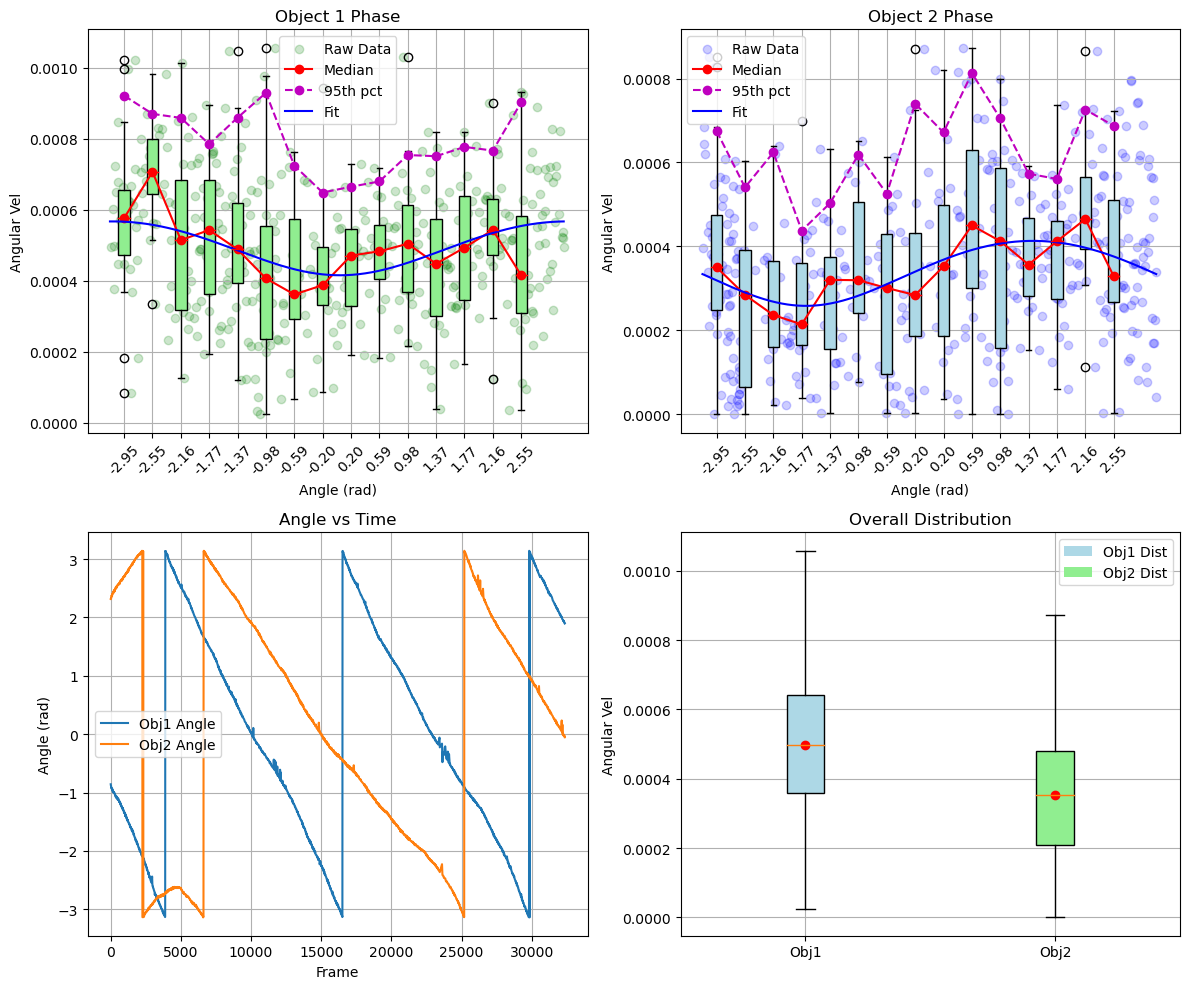

In [42]:
process_folder(r'C:\Users\avsha\Documents\GitHub\Ants\container\vidio 1')
